In [1]:
#!pip install cplex

In [1]:
import ipopt
# Import libraries
import pandas as pd
import numpy as np
import math
import cplex 
import matplotlib.pyplot as plt
%matplotlib inline


### old function


In [2]:
class erc(object):
    def __init__(self):
        pass

    def objective(self, x):
        # The callback for calculating the objective
        y = x * np.dot(Q, x)
        fval = 0
        n=20
        for i in range(n):
            for j in range(i,n):
                xij = y[i] - y[j]
               #print(y[i])
                fval = fval + xij*xij
        fval = 2*fval
        # value
        return fval

    def gradient(self, x):
        # The callback for calculating the gradient
        n=20
        grad = np.zeros(n)
        # Insert your gradient computations here
        f=np.dot(Q,x)
        y = x * f
#         for i in range (n):
#             a=0
#             for j in range(n):
#                 a+= (y[i]-y[j])*f[i]
#             grad[i] = a
                
                
#         grad[i] = 4 *  grad[i] # time 4 because we need divide by 2.

        for i in range(n):
            a=0
            for j in range(n):
                a+= (y[i]-y[j])*(f[i]-Q[i,j]*x[i])
            grad[i] = a   
        grad[i] = 4 *  grad[i] # time 4 because we need divide by 2.
#         for i in range(n):
#             g=0
#             for j in range(n):
#                 diff1 = Q[i,:] * x + Q[i,i] * x[i];
#                 diff2 = Q[i,j] * x[i];
#                 g += (y[i]-y[j]) * (diff1 - diff2);
#             grad[i] = g      
            

        return grad
    

    def constraints(self, x):
        # The callback for calculating the constraints
        n=20
        return [1.0] * n
    
    def jacobian(self, x):
        # The callback for calculating the Jacobian
        n=20
        return np.array([[1.0] * n])

#     def intermediate(
#             self,
#             alg_mod,
#             iter_count,
#             obj_value,
#             inf_pr,
#             inf_du,
#             mu,
#             d_norm,
#             regularization_size,
#             alpha_du,
#             alpha_pr,
#             ls_trials
#             ):

#         # Example for the use of the intermediate callback.
#         print("Objective value at iteration #%d is - %g" % (iter_count, obj_value))

In [3]:


def strat_buy_and_hold(x_init, cash_init, mu, Q, cur_prices):
    x_optimal = x_init
    cash_optimal = cash_init
    return x_optimal, cash_optimal


def strat_equally_weighted(x_init, cash_init, mu, Q, cur_prices):
    
    #xinit curr_positions
    #cash init, left cash, maybe 0 or positive
    # cur_prices  first trading day of each 2-month
    # get the price of each stock

    total_cash= cur_prices@x_init+cash_init
    money_allc=np.ones((20))*total_cash/20
    x_optimal=np.floor(money_allc/cur_prices)
    trac_fee= abs(x_optimal-x_init) @cur_prices * 0.005

    cash_optimal=total_cash-trac_fee- x_optimal @cur_prices 
        
    return x_optimal, cash_optimal

def strat_min_variance(x_init, cash_init, mu, Q, cur_prices):
    total_cash= np.dot(cur_prices, x_init)+cash_init

    n=20 
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [1.0] * n
    #A is for linear constrains
    A = []
    for k in range(n):
        A.append([[0],[1.0]])
    
    var_names = ["w_%s" % i for i in range(1,n+1)]
    
    cpx.linear_constraints.add(rhs=[1.0], senses="E")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A,names=var_names)
    ## above all linear constrain and variable contrains

    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat) 
    
    alg = cpx.parameters.lpmethod.values
#     print("Setting solution algorithm = ", alg.concurrent)
    cpx.parameters.qpmethod.set(alg.concurrent)
    
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
    w_minVar = cpx.solution.get_values()
    w_minVar=np.array(w_minVar)
 
    # new position
    x_optimal= np.floor(w_minVar*total_cash/cur_prices)

    trac_fee=abs(x_optimal-x_init)@cur_prices  *0.005

    cash_optimal=total_cash-trac_fee-x_optimal@cur_prices
    return x_optimal, cash_optimal

def strat_max_Sharpe(x_init, cash_init, mu, Q, cur_prices):
    
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    
    
    total_cash= np.dot(cur_prices, x_init)+cash_init
    
    n=21
    r_rf=0.025
    daily_r_rf=0.025/252
    u_rf=mu-daily_r_rf 
    u_rf_add=np.append(u_rf,0)
    Q=np.append(Q,np.zeros((20,1)),axis=1)
    Q=np.vstack([Q,np.zeros((21))])
   
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    c  = [0.0] * n
    lb = [0.0] * n
    ub = [cplex.infinity] * n

    #A is for linear constrains
    A = []
#     print(u_rf_add)
    for k in range(n):
        if k==20:
            A.append([[0,1],[u_rf_add[k],-1]])
        else:
            A.append([[0,1],[u_rf_add[k],1.0]])
#     print(A)
    var_names = ["y_%s" % i for i in range(1,n+1)]
    
    cpx.linear_constraints.add(rhs=[1.0,0.0], senses="EE")
    cpx.variables.add(obj=c, lb=lb, ub=ub, columns=A,names=var_names)
    ## above all linear constrain and variable contrains    
    Qmat = [[list(range(n)), list(2*Q[k,:])] for k in range(n)]
    cpx.objective.set_quadratic(Qmat)
   
    alg = cpx.parameters.lpmethod.values
#     print("Setting solution algorithm = ", alg.concurrent)
    cpx.parameters.qpmethod.set(alg.concurrent)
    
    cpx.parameters.threads.set(4)
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)

    cpx.solve()
    if cpx.solution.get_status_string()== 'infeasible':
        x_optimal = x_init
        cash_optimal = cash_init
        w_maxSharp = (x_init*cur_prices)/portfolio_value

    else:
  
        # get value
        y_minVar = cpx.solution.get_values()
        y_minVar=np.array(y_minVar)

        w_minVar=y_minVar[0:20]/y_minVar[20]

        x_optimal= np.floor(w_minVar*total_cash/cur_prices)

        trac_fee=abs(x_optimal-x_init)@cur_prices  *0.005

        cash_optimal=total_cash-trac_fee-x_optimal@cur_prices

    
 
    return x_optimal, cash_optimal

### new function

In [4]:


def strat_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
     
    # Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization
    n=20 # 20 stocks
    total_cash= np.dot(cur_prices, x_init)+cash_init
    #w0 = cur_prices * x_init / total_cash
    w0=[1.0/n]*n
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)
#     np.allclose(np.sum(w_erc),1)
#     var_ERC = np.dot(w_erc, np.dot(Q, w_erc))
#     std_ERC = np.sqrt(var_ERC)
#     RC_ERC = (w_erc * np.dot(Q, w_erc)) / std_ERC

    x_optimal = np.floor(w_erc * total_cash / cur_prices) #%20*1

    trac_fee=abs(x_optimal-x_init)@cur_prices  *0.005
    cash_optimal=total_cash-trac_fee-x_optimal@cur_prices
    return x_optimal, cash_optimal



def strat_lever_equal_risk_contr(x_init, cash_init, mu, Q, cur_prices):
    # Use "1/n portfolio" w0 as initial portfolio for starting IPOPT optimization
    n=20 # 20 stocks
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    
    
    total_cash= np.dot(cur_prices, x_init)+cash_init
###### 
    borrowed_fund = init_value
    if period == 1:
        total_cash = total_cash + borrowed_fund
  
    period_interest = borrowed_fund * r_rf/6
#######

   # w0 = cur_prices * x_init / total_cash
    w0=[1.0/n]*n
    
    lb = [0.0] * n  # lower bounds on variables
    ub = [1.0] * n  # upper bounds on variables
    cl = [1]        # lower bounds on constraints
    cu = [1]        # upper bounds on constraints

    # Define IPOPT problem
    nlp = ipopt.problem(n=len(w0), m=len(cl), problem_obj=erc(), lb=lb, ub=ub, cl=cl, cu=cu)

    # Set the IPOPT options
    nlp.addOption('jac_c_constant'.encode('utf-8'), 'yes'.encode('utf-8'))
    nlp.addOption('hessian_approximation'.encode('utf-8'), 'limited-memory'.encode('utf-8'))
    nlp.addOption('mu_strategy'.encode('utf-8'), 'adaptive'.encode('utf-8'))
    nlp.addOption('tol'.encode('utf-8'), 1e-10)

    # Solve the problem
    w_erc, info = nlp.solve(w0)

    w_erc = w_erc*(1/w_erc.sum())
    
    x_optimal = np.floor(w_erc * total_cash / cur_prices) #%20*1

    trac_fee=abs(x_optimal-x_init)@cur_prices  *0.005
    cash_optimal=total_cash-trac_fee-x_optimal@cur_prices-period_interest


    return x_optimal, cash_optimal




def strat_robust_optim(x_init, cash_init, mu, Q, cur_prices):
    if cur_year == 2008:
        r_rf = 0.045
    else:
        r_rf = 0.025
    total_cash= np.dot(cur_prices, x_init)+cash_init
#     x_,y_=strat_min_variance(x_init, cash_init, mu, Q, cur_prices)
#     w_minVar=x_*cur_prices/total_cash
#     ret_minVar = np.dot(mu, w_minVar)  # scale time 1.2
    
    n=20
 
    var_names = ["w_%s" % i for i in range(1,n+1)]
    cpx = cplex.Cplex()
    cpx.objective.set_sense(cpx.objective.sense.minimize)
    #initial portfolio weight
    #w0 = cur_prices * x_init / total_cash
    w0=[1.0/n]*n
    ret_init=np.dot(mu,w0)
    var_init=np.dot(w0,np.dot(Q,w0))
    
    
    # target portfolio return estimation error
    var_matr=np.diag(np.diag(Q))
    rob_init=np.dot(w0,np.dot(var_matr,w0))
    rob_bnd=rob_init
    
    
    #Portf_Retn = r_rf/252
    Portf_Retn =r_rf/252
    c=[0.0]*n
    lb=[0.0]*n
    ub=[1.0]*n
    A=[]
    
    #Contrain
    for k in range(n):
        A.append([[0,1],[1.0,mu[k]]])
    cpx.linear_constraints.add(rhs=[1.0,Portf_Retn],senses="EG")
    
    cpx.variables.add(obj=c,lb=lb,ub=ub,columns=A,names=var_names)
    Qmat=[[list(range(n)),list(2*Q[k,:])] for k in range(n)]

    cpx.objective.set_quadratic(Qmat)
    Qcon=cplex.SparseTriple(ind1=var_names,ind2=range(n),val=np.diag(var_matr))
    cpx.quadratic_constraints.add(rhs=rob_bnd,quad_expr=Qcon,name='Qc')
    cpx.set_results_stream(None)
    cpx.set_warning_stream(None)
    cpx.solve()
      
    if cpx.solution.get_status_string()== 'infeasible':
        x_optimal = x_init
        cash_optimal = cash_init

    else:
        w_minVar = cpx.solution.get_values()
        w_minVar=np.array(w_minVar)

        x_optimal = np.floor(w_minVar * total_cash / cur_prices) #%20*1
        trac_fee=abs(x_optimal-x_init)@cur_prices  *0.005
        cash_optimal=total_cash-trac_fee-x_optimal@cur_prices

    return x_optimal, cash_optimal



    

# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]


### implement 2015-2016


In [5]:


    

# Input file
input_file_prices = 'Daily_closing_prices.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]



dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2014)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045
# interest
#period_interest = init_value * r_rf/6

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  # comment this in your codeIf 
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe,strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 15:
        cur_year  = 15 + math.floor(period/7)
    else:
        cur_year  = 2015 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy  in range(N_strat):

        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        ###################### Insert your code here ############################

        if cash[strategy][period-1] < 0:
            if cash[5,0]<0:
                portfolio_value = (np.dot(cur_prices,curr_positions) + curr_cash)*2
            else:
                portfolio_value = np.dot(cur_prices,curr_positions) + curr_cash
                
            ratio = x[strategy][period-1] / (sum(x[strategy][period-1]))
            cash_balance = abs(cash[strategy][period-1])* ratio
            position_balance = np.ceil(cash_balance / cur_prices)
            x[strategy][period-1] = x[strategy][period-1] - position_balance
            new_transaction = np.dot(cur_prices , abs(x[strategy][period-1] - curr_positions) )* 0.005
            cash[strategy][period-1] = portfolio_value - np.dot(cur_prices , x[strategy][period-1]) - new_transaction

        
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        if strategy ==5:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value  ## here is the borrowed money
        else:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy],portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
        

    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)

# Plot results



Initial portfolio value = $ 1000002.12


Period 1: start date 1/2/2015, end date 2/27/2015
  Strategy "Buy and Hold", value begin = $ 1000002.12, value end = $ 1043785.08
  Strategy "Equally Weighted Portfolio", value begin = $ 992880.88, value end = $ 1020038.79
  Strategy "Mininum Variance Portfolio", value begin = $ 991454.43, value end = $ 1016159.03
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 990052.34, value end = $ 1007863.43
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 992749.72, value end = $ 1018447.55
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 989687.14, value end = $ 1041196.71
  Strategy "Robust Optimization Portfolio", value begin = $ 992226.89, value end = $ 1002762.09

Period 2: start date 3/2/2015, end date 4/30/2015
  Strategy "Buy and Hold", value begin = $ 1045234.09, value end = $ 1069877.19
  Strategy "Equally Weighted Portfolio", value begin = $ 1030724.21, value end = $ 1011178.46
  Strategy "

  Strategy "Mininum Variance Portfolio", value begin = $ 1006897.18, value end = $ 1120976.00
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 1157455.31, value end = $ 1535893.12
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 1132945.06, value end = $ 1242963.62
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 1270150.84, value end = $ 1489999.53
  Strategy "Robust Optimization Portfolio", value begin = $ 1048512.13, value end = $ 1134668.85


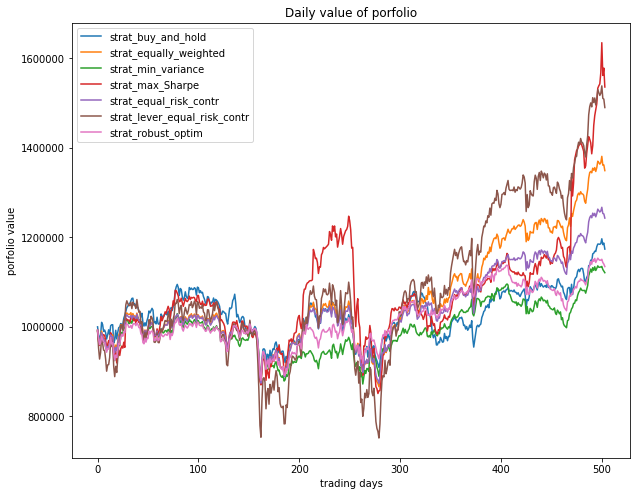

In [6]:
plt.figure(figsize=(10,8))
for i in range(7):
    plt.plot(portf_value[i],label=strategy_functions[i])

plt.legend(loc="best")
plt.title("Daily value of porfolio")
plt.ylabel("porfolio value")
plt.xlabel("trading days")

plt.show()

Text(0.5, 0, 'trading period')

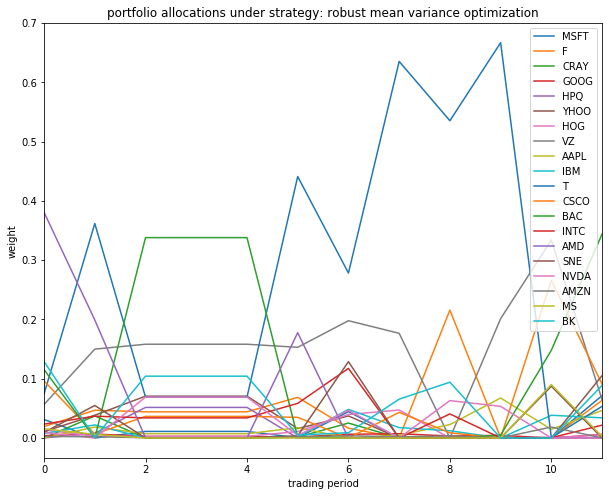

In [7]:
stock_name=df.columns[1:,]
w_min_var=[]
for period in range(1,N_periods+1):
    w_min_var.append(x[6, period-1]/sum(x[6, period-1]))
b=np.array(w_min_var)
df_stockweight=pd.DataFrame(b,columns=stock_name)
df_stockweight.plot(figsize=(10,8))
plt.legend(loc="upper right")


plt.title("portfolio allocations under strategy: robust mean variance optimization")
plt.ylabel("weight")
plt.xlabel("trading period")

Text(0.5, 0, 'trading period')

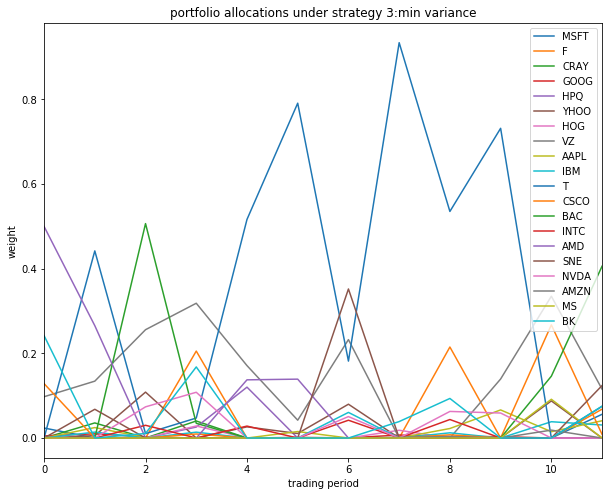

In [8]:
stock_name=df.columns[1:,]
w_min_var=[]
for period in range(1,N_periods+1):
    w_min_var.append(x[2, period-1]/sum(x[2, period-1]))
b=np.array(w_min_var)
df_stockweight=pd.DataFrame(b,columns=stock_name)
df_stockweight.plot(figsize=(10,8))
plt.legend(loc="upper right")


plt.title("portfolio allocations under strategy 3:min variance")
plt.ylabel("weight")
plt.xlabel("trading period")

Text(0.5, 0, 'trading period')

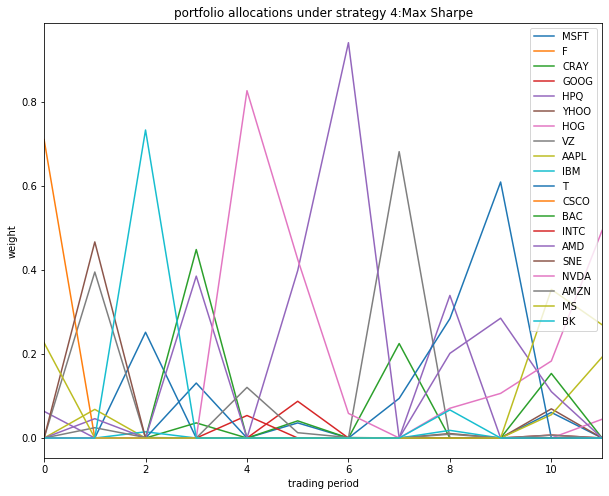

In [9]:
stock_name=df.columns[1:,]
w_min_var=[]
for period in range(1,N_periods+1):
    w_min_var.append(x[3, period-1]/sum(x[3, period-1]))
b=np.array(w_min_var)
df_stockweight=pd.DataFrame(b,columns=stock_name)
df_stockweight.plot(figsize=(10,8))
plt.legend(loc="upper right")


plt.title("portfolio allocations under strategy 4:Max Sharpe")
plt.ylabel("weight")
plt.xlabel("trading period")

### 2008-2009

In [10]:

# Input file
input_file_prices = 'Daily_closing_prices20082009.csv'

# Read data into a dataframe
df = pd.read_csv(input_file_prices)

# Convert dates into array [year month day]
def convert_date_to_array(datestr):
    temp = [int(x) for x in datestr.split('/')]
    return [temp[-1], temp[0], temp[1]]

dates_array = np.array(list(df['Date'].apply(convert_date_to_array)))
data_prices = df.iloc[:, 1:].to_numpy()
dates = np.array(df['Date'])
# Find the number of trading days in Nov-Dec 2014 and
# compute expected return and covariance matrix for period 1
day_ind_start0 = 0
day_ind_end0 = len(np.where(dates_array[:,0]==2007)[0])
cur_returns0 = data_prices[day_ind_start0+1:day_ind_end0,:] / data_prices[day_ind_start0:day_ind_end0-1,:] - 1
mu = np.mean(cur_returns0, axis = 0)
Q = np.cov(cur_returns0.T)

# Remove datapoints for year 2014
data_prices = data_prices[day_ind_end0:,:]
dates_array = dates_array[day_ind_end0:,:]
dates = dates[day_ind_end0:]

# Initial positions in the portfolio
init_positions = np.array([5000, 950, 2000, 0, 0, 0, 0, 2000, 3000, 1500, 0, 0, 0, 0, 0, 0, 1001, 0, 0, 0])

# Initial value of the portfolio
init_value = np.dot(data_prices[0,:], init_positions)
print('\nInitial portfolio value = $ {}\n'.format(round(init_value, 2)))

# Initial portfolio weights
w_init = (data_prices[0,:] * init_positions) / init_value

# Number of periods, assets, trading days
N_periods = 6*len(np.unique(dates_array[:,0])) # 6 periods per year
N = len(df.columns)-1
N_days = len(dates)

# Annual risk-free rate for years 2015-2016 is 2.5%
r_rf = 0.025
# Annual risk-free rate for years 2008-2009 is 4.5%
r_rf2008_2009 = 0.045


#period_interest=init_value*r_rf2008_2009/6

# Number of strategies
strategy_functions = ['strat_buy_and_hold', 'strat_equally_weighted', 'strat_min_variance', 'strat_max_Sharpe', 'strat_equal_risk_contr', 'strat_lever_equal_risk_contr', 'strat_robust_optim']
strategy_names     = ['Buy and Hold', 'Equally Weighted Portfolio', 'Mininum Variance Portfolio', 'Maximum Sharpe Ratio Portfolio', 'Equal Risk Contributions Portfolio', 'Leveraged Equal Risk Contributions Portfolio', 'Robust Optimization Portfolio']
#N_strat = 1  # comment this in your code
N_strat = len(strategy_functions)  # uncomment this in your code
fh_array = [strat_buy_and_hold, strat_equally_weighted, strat_min_variance, strat_max_Sharpe,strat_equal_risk_contr, strat_lever_equal_risk_contr, strat_robust_optim]

portf_value = [0] * N_strat
x = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
cash = np.zeros((N_strat, N_periods),  dtype=np.ndarray)
for period in range(1, N_periods+1):
    # Compute current year and month, first and last day of the period
    if dates_array[0, 0] == 8:
        cur_year  = 8 + math.floor(period/7)
    else:
        cur_year  = 2008 + math.floor(period/7)

    cur_month = 2*((period-1)%6) + 1
    day_ind_start = min([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month)) if val])
    day_ind_end = max([i for i, val in enumerate((dates_array[:,0] == cur_year) & (dates_array[:,1] == cur_month+1)) if val])
    print('\nPeriod {0}: start date {1}, end date {2}'.format(period, dates[day_ind_start], dates[day_ind_end]))

    # Prices for the current day
    cur_prices = data_prices[day_ind_start,:]

    # Execute portfolio selection strategies
    for strategy  in range(N_strat):

        # Get current portfolio positions
        if period == 1:
            curr_positions = init_positions
            curr_cash = 0
            portf_value[strategy] = np.zeros((N_days, 1))
        else:
            curr_positions = x[strategy, period-2]
            curr_cash = cash[strategy, period-2]

        # Compute strategy
        x[strategy, period-1], cash[strategy, period-1] = fh_array[strategy](curr_positions, curr_cash, mu, Q, cur_prices)

        # Verify that strategy is feasible (you have enough budget to re-balance portfolio)
        # Check that cash account is >= 0
        # Check that we can buy new portfolio subject to transaction costs

        ###################### Insert your code here ############################

        if cash[strategy][period-1] < 0:
            if cash[5,0]<0:
                portfolio_value = (np.dot(cur_prices,curr_positions) + curr_cash)*2
            else:
                portfolio_value = np.dot(cur_prices,curr_positions) + curr_cash
                
            ratio = x[strategy][period-1] / (sum(x[strategy][period-1]))
            cash_balance = abs(cash[strategy][period-1])* ratio
            position_balance = np.ceil(cash_balance / cur_prices)
            x[strategy][period-1] = x[strategy][period-1] - position_balance
            new_transaction = np.dot(cur_prices , abs(x[strategy][period-1] - curr_positions) )* 0.005
            cash[strategy][period-1] = portfolio_value - np.dot(cur_prices , x[strategy][period-1]) - new_transaction

#         if cash[strategy, period-1] < 0:
#             if cash[5,0]<0:
#                 portfolio_value = (np.dot(cur_prices,curr_positions) + curr_cash) * 2
#             else:
#                 portfolio_value = np.dot(cur_prices,curr_positions) + curr_cash
                
#             ratio = x[strategy, period-1]/sum(x[strategy, period-1])
#             minus_cash = abs(cash[strategy, period-1])*ratio
#             minus_position = np.ceil(minus_cash/cur_prices)
#             x[strategy, period-1] = x[strategy, period-1] - minus_position
#             new_tran_cost = np.dot(cur_prices , abs(x[strategy, period-1]-curr_positions)) * 0.005
#             cash[strategy, period-1] = portfolio_value - np.dot(cur_prices,x[strategy, period-1]) - new_tran_cost -init_value*0.025/6
#         # Compute portfolio value
        
        
        p_values = np.dot(data_prices[day_ind_start:day_ind_end+1,:], x[strategy, period-1]) + cash[strategy, period-1]
        if strategy ==5:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1)) - init_value  ## here is the borrowed money
        else:
            portf_value[strategy][day_ind_start:day_ind_end+1] = np.reshape(p_values, (p_values.size,1))
        print('  Strategy "{0}", value begin = $ {1:.2f}, value end = $ {2:.2f}'.format( strategy_names[strategy],portf_value[strategy][day_ind_start][0], portf_value[strategy][day_ind_end][0]))
        

    # Compute expected returns and covariances for the next period
    cur_returns = data_prices[day_ind_start+1:day_ind_end+1,:] / data_prices[day_ind_start:day_ind_end,:] - 1
    mu = np.mean(cur_returns, axis = 0)
    Q = np.cov(cur_returns.T)

# Plot results
###################### Insert your code here ############################


Initial portfolio value = $ 548247.97


Period 1: start date 1/2/2008, end date 2/29/2008
  Strategy "Buy and Hold", value begin = $ 548247.97, value end = $ 465217.72
  Strategy "Equally Weighted Portfolio", value begin = $ 544330.39, value end = $ 470120.05
  Strategy "Mininum Variance Portfolio", value begin = $ 543920.12, value end = $ 461622.35
  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 542793.11, value end = $ 473586.09
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 544298.16, value end = $ 471812.43
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 542914.17, value end = $ 397951.87
  Strategy "Robust Optimization Portfolio", value begin = $ 544726.59, value end = $ 457822.73

Period 2: start date 3/3/2008, end date 4/30/2008
  Strategy "Buy and Hold", value begin = $ 462553.95, value end = $ 511257.48
  Strategy "Equally Weighted Portfolio", value begin = $ 463836.30, value end = $ 510330.06
  Strategy "Mininum Varia

  Strategy "Maximum Sharpe Ratio Portfolio", value begin = $ 277740.04, value end = $ 314252.82
  Strategy "Equal Risk Contributions Portfolio", value begin = $ 467768.70, value end = $ 523167.12
  Strategy "Leveraged Equal Risk Contributions Portfolio", value begin = $ 388457.72, value end = $ 499007.44
  Strategy "Robust Optimization Portfolio", value begin = $ 420897.88, value end = $ 468438.34


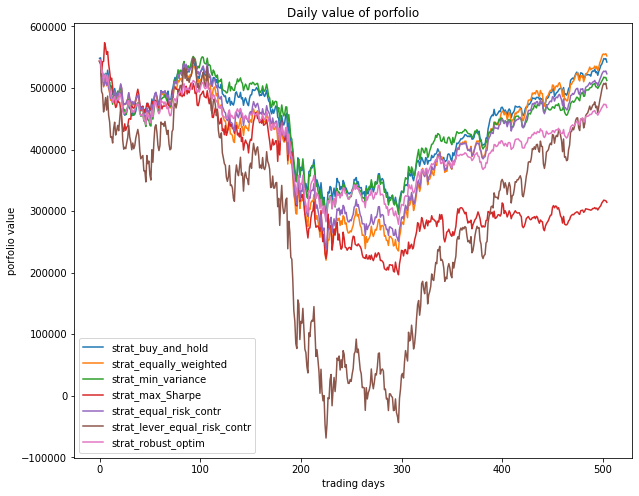

In [11]:
plt.figure(figsize=(10,8))
for i in range(7):
    plt.plot(portf_value[i],label=strategy_functions[i])

plt.legend(loc="best")
plt.title("Daily value of porfolio")
plt.ylabel("porfolio value")
plt.xlabel("trading days")

plt.show()

Text(0.5, 0, 'trading period')

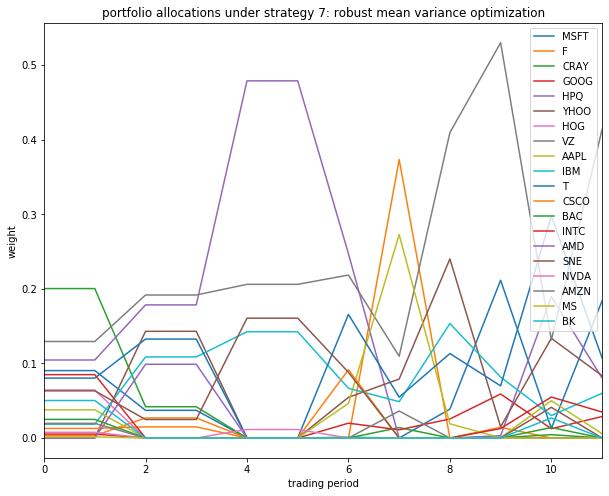

In [12]:
stock_name=df.columns[1:,]
w_min_var=[]
for period in range(1,N_periods+1):
    w_min_var.append(x[6, period-1]/sum(x[6, period-1]))
b=np.array(w_min_var)
df_stockweight=pd.DataFrame(b,columns=stock_name)
df_stockweight.plot(figsize=(10,8))
plt.legend(loc="upper right")


plt.title("portfolio allocations under strategy 7: robust mean variance optimization")
plt.ylabel("weight")
plt.xlabel("trading period")

Text(0.5, 0, 'trading period')

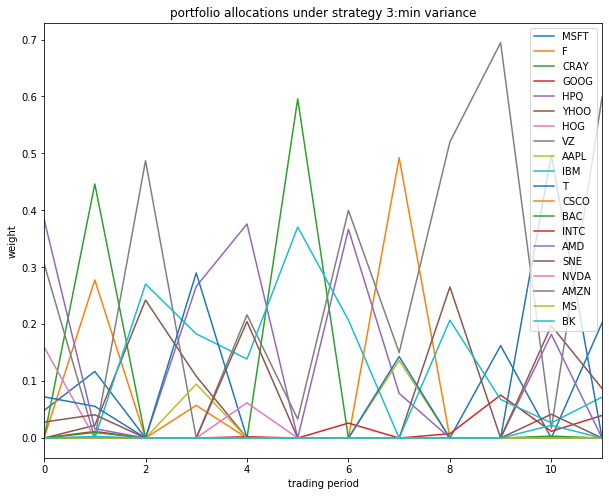

In [13]:
stock_name=df.columns[1:,]
w_min_var=[]
for period in range(1,N_periods+1):
    w_min_var.append(x[2, period-1]/sum(x[2, period-1]))
b=np.array(w_min_var)
df_stockweight=pd.DataFrame(b,columns=stock_name)
df_stockweight.plot(figsize=(10,8))
plt.legend(loc="upper right")


plt.title("portfolio allocations under strategy 3:min variance")
plt.ylabel("weight")
plt.xlabel("trading period")


Text(0.5, 0, 'trading period')

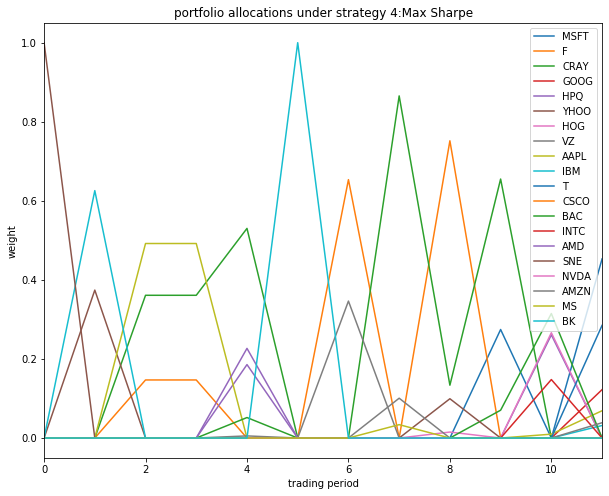

In [14]:
stock_name=df.columns[1:,]
w_min_var=[]
for period in range(1,N_periods+1):
    w_min_var.append(x[3, period-1]/sum(x[3, period-1]))
b=np.array(w_min_var)
df_stockweight=pd.DataFrame(b,columns=stock_name)
df_stockweight.plot(figsize=(10,8))
plt.legend(loc="upper right")


plt.title("portfolio allocations under strategy 4:Max Sharpe")
plt.ylabel("weight")
plt.xlabel("trading period")